In [1]:
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.datasets import make_moons, make_blobs
from IPython.display import HTML #we need this for displaying an animation when using an .ipynb file

In [2]:
import pyflashlight.nn as nn
import pyflashlight.losses as losses
import pyflashlight.helpers as helpers
from pyflashlight.engine import Scalar, Vector

In [3]:
random.seed(42)

First, we will download and visualize a dataset. 

First five X values:
 [[ 0.07265605  0.02035714]
 [ 1.67091945 -0.34251137]
 [-0.8689238   0.14528854]
 [-0.32658847  1.00971319]
 [-0.00248564  0.52654021]]

First five y values:
 [1 1 0 0 1]


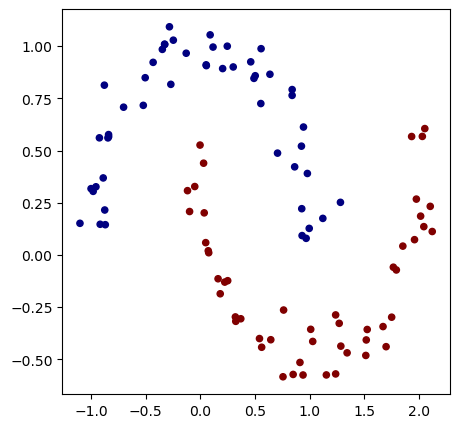

In [4]:
# First, we will download and visualize a dataset in 2D
X, y = make_moons(n_samples=100, noise=0.1)
print(f"First five X values:\n {X[:5]}\n")
print(f"First five y values:\n {y[:5]}")
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

Now, we will instantiate the model and the training data using PyFlashlight. 

In [5]:
model = nn.MLP(2, [16, 16, 1], activ='leakyrelu') # 2-layer neural network
model.layers[2].neurons[0].activ='sigmoid'
print(model)
print("number of parameters", len(model.parameters()))

Xs = [Vector(x) for x in X]
ys = Vector(y)

number of parameters 337


In [6]:
model.parameters()

[Scalar(data=0.2788535969157675, grad=0.0, label=L0w0-\>L1w0),
 Scalar(data=-0.9499784895546661, grad=0.0, label=L0w1-\>L1w0),
 Scalar(data=-0.4499413632617615, grad=0.0, label=L1b0),
 Scalar(data=-0.5535785237023545, grad=0.0, label=L0w0-\>L1w1),
 Scalar(data=0.4729424283280248, grad=0.0, label=L0w1-\>L1w1),
 Scalar(data=0.3533989748458226, grad=0.0, label=L1b1),
 Scalar(data=0.7843591354096908, grad=0.0, label=L0w0-\>L1w2),
 Scalar(data=-0.8261223347411677, grad=0.0, label=L0w1-\>L1w2),
 Scalar(data=-0.15615636062945915, grad=0.0, label=L1b2),
 Scalar(data=-0.9404055611238593, grad=0.0, label=L0w0-\>L1w3),
 Scalar(data=-0.5627240503927933, grad=0.0, label=L0w1-\>L1w3),
 Scalar(data=0.010710576206724776, grad=0.0, label=L1b3),
 Scalar(data=-0.9469280606322728, grad=0.0, label=L0w0-\>L1w4),
 Scalar(data=-0.602324698626703, grad=0.0, label=L0w1-\>L1w4),
 Scalar(data=0.2997688755590464, grad=0.0, label=L1b4),
 Scalar(data=0.08988296120643335, grad=0.0, label=L0w0-\>L1w5),
 Scalar(data=-0

We also need to define some information for plotting predicted contours later on

In [7]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [Vector(xrow) for xrow in Xmesh]
Zs = []

Let's train!

In [9]:
NUM_EPOCHS = 40
for epoch in range(NUM_EPOCHS):

    # Forward pass
    model.zero_grad()
    y_preds = list(map(model, Xs))
    loss = losses.binary_cross_entropy(ys, y_preds)

    # Back propagation
    loss.backward()

    # Gradient descent (using the entire training set)
    learning_rate = 1.0 - 0.9*epoch/NUM_EPOCHS
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    print(epoch, loss.data)

    # Calculating predicted contour
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0.5 for s in scores])
    Z = Z.reshape(xx.shape)
    Zs.append(Z)


0 0.9756904185815489
1 2.5790851021973817
2 0.8260304125186991
3 0.27933090810805833
4 0.21859434777305425
5 0.19830989733942783
6 0.1834896915117842
7 0.17109049623360936
8 0.15997236265755535
9 0.15050009253118216
10 0.1423291654236814
11 0.13560245178544883
12 0.12821576804921686
13 0.12232765646651078
14 0.1170566903523327
15 0.11242827862551813
16 0.10794950154136981
17 0.10386617429315634
18 0.10037801241164372
19 0.0970249493902638
20 0.09370026292607925
21 0.09079974741667284
22 0.08807979031430631
23 0.08555152012254957
24 0.08318879326297646
25 0.08109365609290581
26 0.07915715737494491
27 0.07723393509751923
28 0.07553330611745696
29 0.07398498636011415
30 0.0726158021256134
31 0.07131537451720645
32 0.07010899145582392
33 0.06902487395898231
34 0.06805421980513884
35 0.06722194373086147
36 0.06643502679560247
37 0.06574216148045364
38 0.06511372783795888
39 0.06457356174151987


Since we stored predictions of a background meshgrid for each epoch during training (`Zs`), we can visualize how the model learned over time.

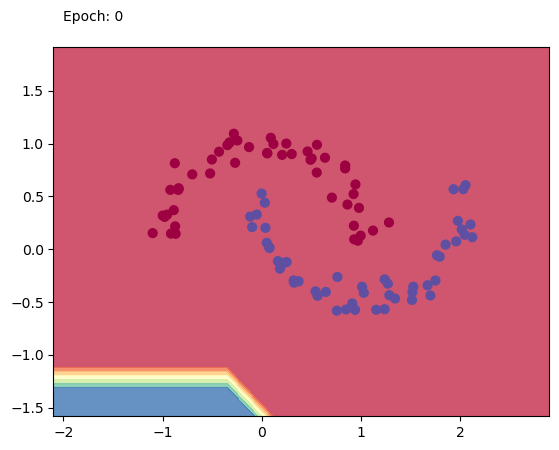

In [11]:
fig, ax = plt.subplots()
cf = ax.contourf(xx, yy, Zs[0], cmap=plt.cm.Spectral, alpha=0.8)
sct = ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
txt = ax.text(-2.0,2.2, f"Epoch: 0", va='center')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max()) 

def animate(i):
    global cf
    for coll in cf.collections:
        coll.remove()
    Z = Zs[i]
    cf = ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    sct = ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    txt.set_text(f"Epoch: {i}")   

    return cf

anim = animation.FuncAnimation(fig, animate, frames=len(Zs), repeat=False)

plt.show()
HTML(anim.to_html5_video())

In [14]:
#anim.save('./images/moons_training.gif', writer='imagemagick')
    